### Recommend anime dựa theo phương pháp item-based
- Ánh xạ các đặt tính của phim thành vector embedding
- Tìm phim tương đồng với phim mà người dùng thích nhất hoặc phim không tương đồng với phim mà người dùng đã đánh giá thấp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from functools import *

- Lấy bảng dữ liệu từ dataset

In [2]:
anime = pd.read_csv("Dataset/preprocessed_anime.csv")

In [3]:
anime.head(5)

,anime_id,name,genre,type,episodes,rating,members,n_genres,genre_primary
0,32281,Kimi no Na wa.,"Drama,Romance,School,Supernatural",Movie,1,9.37,200630,4,drama
1,5114,Fullmetal Alchemist: Brotherhood,"Action,Adventure,Drama,Fantasy,Magic,Military,...",TV,64,9.26,793665,7,action
2,28977,Gintama°,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",TV,51,9.25,114262,7,action
3,9253,Steins;Gate,"Sci-Fi,Thriller",TV,24,9.17,673572,2,sci-fi
4,9969,Gintama&#039;,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",TV,51,9.16,151266,7,action


In [4]:
anime.shape

(12017, 9)

In [5]:
def build_description_for_type(types: list):
    def map_type(type: str):
        if type == 'TV':
            return 'Television'
        elif type == 'OVA':
            return 'Original Video Animation'
        elif type == 'ONA':
            return 'Orginal Net Animation'
        
        return type
    
    return list(map(map_type, types))

- Xử lý một chút vấn đề data type ở cột episodes

In [6]:
anime['episodes'] = anime['episodes'].apply(lambda x: 2 if x == 'Unknown' else x)

In [7]:
anime['episodes'] = pd.to_numeric(anime['episodes'], errors='coerce').astype('Int16')

In [8]:
anime.describe()

,anime_id,episodes,rating,members,n_genres
count,12017.000000,12017.0,12017.000000,1.201700e+04,12017.000000
mean,13638.001165,12.323542,6.478264,1.834888e+04,2.961971
std,11231.076675,46.747242,1.023857,5.537250e+04,1.665664
min,1.000000,1.0,1.670000,1.200000e+01,1.000000
25%,3391.000000,1.0,5.890000,2.250000e+02,2.000000
50%,9959.000000,2.0,6.570000,1.552000e+03,3.000000
75%,23729.000000,12.0,7.180000,9.588000e+03,4.000000
max,34519.000000,1818.0,10.000000,1.013917e+06,13.000000


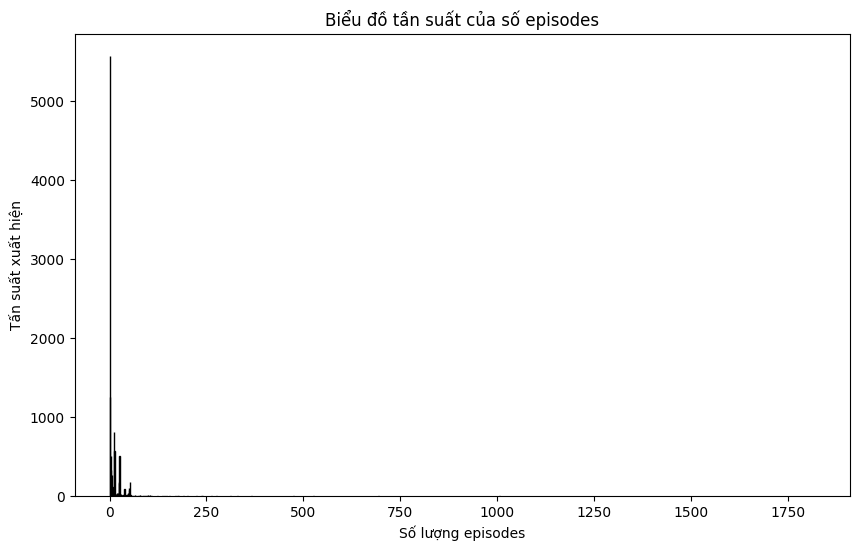

In [9]:
counts = anime['episodes'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values, color='red', edgecolor='black')

plt.xlabel('Số lượng episodes')
plt.ylabel('Tấn suất xuất hiện')
plt.title('Biểu đồ tần suất của số episodes')
plt.show()

- Từ biểu đồ tần suất và dữ liệu thống kê cho thấy:
    - Giá trị episodes nằm dưới giá trị trung vị nên được cho là những phim có số tập ngắn -> Short Anime
    - Từ giá trị trung vị đến 75% là những phim có số tập trung bình -> Medium-length anime
    - Trên mức đó thì phim có số tập dài -> long-running anime

In [10]:
def build_description_for_episodes(episodes: list):
    def map_episodes(episode: int):
        if episode <= 1:
            return "Short Anime"
        elif episode > 1 and episode <= 3:
            return "Medium-length Anime"
        elif episode >= 13 and episode <= 100:
            return "Long-running Anime"
        return "Long-running Series"
    
    return list(map(map_episodes, episodes))
        

In [11]:
episodes_copy = build_description_for_episodes(anime['episodes'])
print(episodes_copy)

['Short Anime', 'Long-running Anime', 'Long-running Anime', 'Long-running Anime', 'Long-running Anime', 'Long-running Series', 'Long-running Series', 'Long-running Series', 'Short Anime', 'Long-running Anime', 'Long-running Anime', 'Short Anime', 'Long-running Series', 'Long-running Anime', 'Long-running Anime', 'Short Anime', 'Long-running Anime', 'Long-running Series', 'Short Anime', 'Long-running Anime', 'Long-running Anime', 'Long-running Series', 'Long-running Anime', 'Long-running Series', 'Short Anime', 'Short Anime', 'Long-running Anime', 'Long-running Series', 'Long-running Anime', 'Long-running Anime', 'Long-running Anime', 'Long-running Anime', 'Long-running Anime', 'Short Anime', 'Long-running Anime', 'Short Anime', 'Long-running Series', 'Short Anime', 'Long-running Anime', 'Long-running Anime', 'Long-running Anime', 'Medium-length Anime', 'Long-running Anime', 'Long-running Anime', 'Long-running Anime', 'Short Anime', 'Long-running Anime', 'Long-running Series', 'Short An

- Trực quan hóa dữ liệu phân loại độ dài

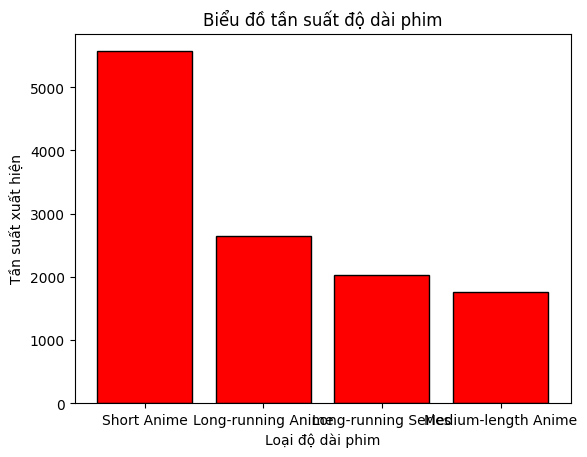

In [12]:
counts = Counter(episodes_copy)

plt.bar(counts.keys(), counts.values(), color='red', edgecolor="black")

plt.xlabel('Loại độ dài phim')
plt.ylabel('Tần suất xuất hiện')
plt.title('Biểu đồ tần suất độ dài phim')
plt.show()

- Tiếp tục đánh giá độ yêu thích của phim qua rating trung bình

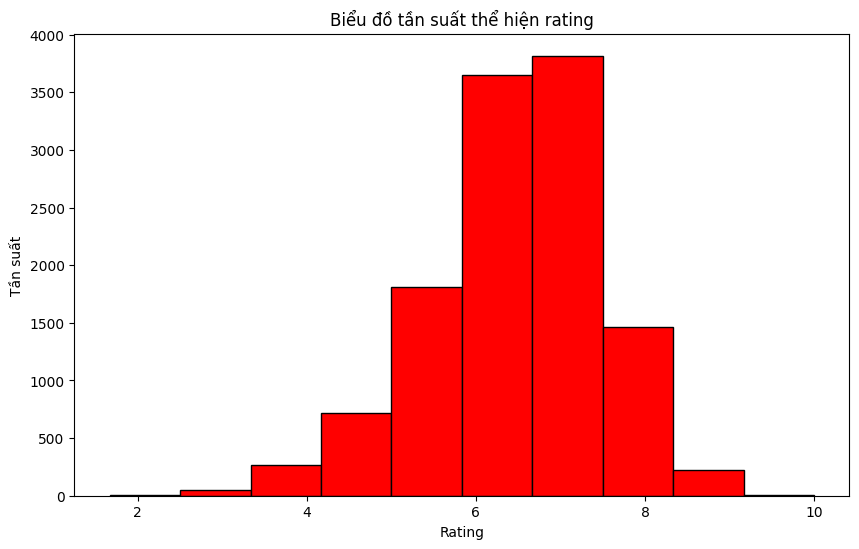

In [13]:

plt.figure(figsize=(10, 6))

plt.hist(anime['rating'], color='red', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Tần suất')
plt.title('Biểu đồ tần suất thể hiện rating')

plt.show()

- Dựa vào biểu đồ tần suất và giá trị thống kê bên trên ta kết luận dữ liệu rating phim như sau:
    - Đầu tiên, dữ liệu khá lệch phải, phân vị thứ nhất là 5.89, trung vị là 6.57, phân vị thứ ba là 7.19.
    - Chứng tỏ khá ít phim đạt được điểm > 8 -> nhóm này là nhóm được yêu thích
    - Ở khoảng giữa nhóm trung bình sẽ có số điểm từ 6 đến dưới 8
    - Thấp hơn 6 sẽ là nhóm phim tệ

In [14]:
def build_description_for_rating(ratings: list):
    def map_rating(rating: float):
        if rating >= 8:
            return 'Top-rated'
        elif rating >= 6 and rating < 8:
            return 'Decent'
        
        return 'Bad'
        
    return list(map(map_rating, ratings))

In [15]:
rating_copy = build_description_for_rating(anime['rating'])
print(rating_copy)

['Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated', 'Top-rated'

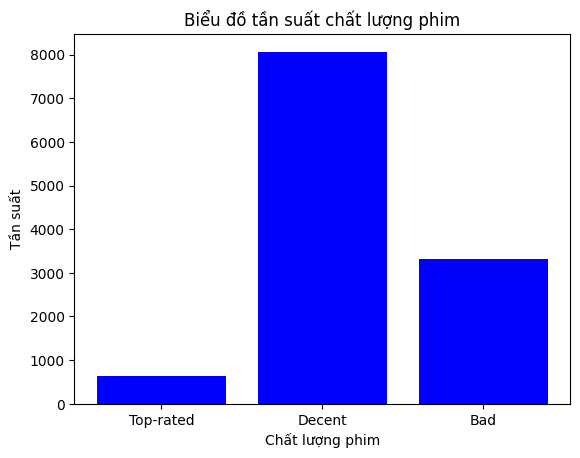

In [16]:
counts = Counter(rating_copy)

plt.bar(counts.keys(), counts.values(), color='blue')

plt.xlabel('Chất lượng phim')
plt.ylabel('Tần suất')
plt.title('Biểu đồ tần suất chất lượng phim')
plt.show()

- Xử lý tính chất phổ biển thông qua members

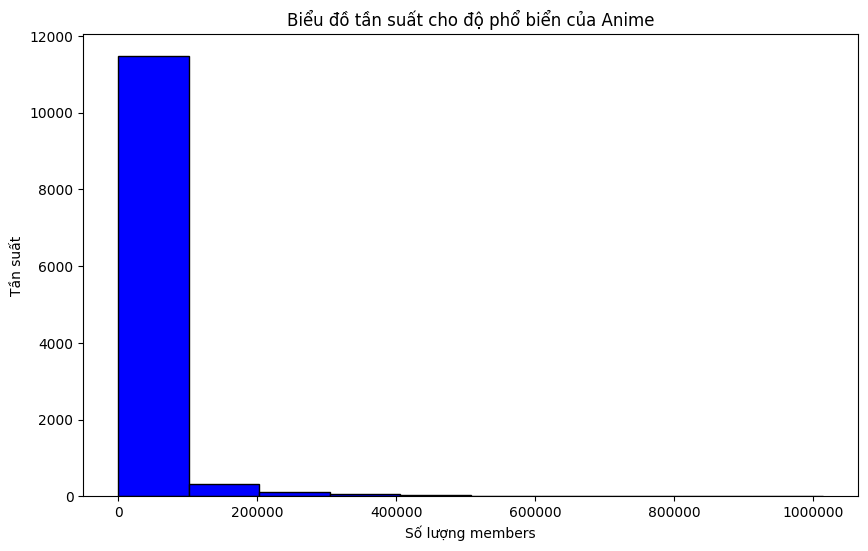

In [17]:

plt.figure(figsize=(10, 6))
plt.hist(anime['members'], bins=10, color='blue', edgecolor='black')

plt.xlabel('Số lượng members')
plt.ylabel('Tần suất')
plt.title('Biểu đồ tần suất cho độ phổ biển của Anime')
plt.ticklabel_format(style='plain', axis='x')  # <-- Tắt 1e6

plt.show()

- Dựa vào dữ liệu thống kê trên tập members, ta có nhận xét như sau:
    - Đầu tiên, Phân vị thứ nhất là 232, trung vị là 1589, phân vị thứ 3 là 9832. Dữ liệu từ histogram không quá rõ.
    - Từ các điểm phân vị ta có:
        - Nếu có dưới 300 members, nghĩa là phim thuộc nhóm Less Popular
        - Từ 300 đến dưới 10000, nghĩa là phim thuộc nhóm Popular
        - Từ 10000 trở lên, nghĩa là phim thuộc nhóm Viral

In [18]:
def build_description_for_members(members: list):
    def map_popularity(member: float):
        if member >= 10000:
            return 'Viral'
        elif member >= 300 and member < 10000:
            return 'Popular'
        return 'Niche'

    return list(map(map_popularity, members)) 

In [19]:
members_copy = build_description_for_members(anime['members'])
print(members_copy)

['Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 'Viral', 

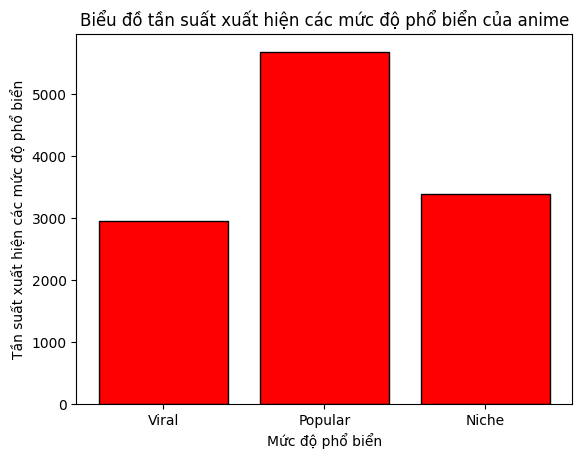

In [20]:
counts = Counter(members_copy)

plt.bar(counts.keys(), counts.values(), color='red', edgecolor='black')

plt.xlabel('Mức độ phổ biển')
plt.ylabel('Tần suất xuất hiện các mức độ phổ biển')
plt.title('Biểu đồ tần suất xuất hiện các mức độ phổ biển của anime')

plt.show()

- Ta cần xây dựng một hàm map tất cả dữ liệu của mỗi phim lại thành một đoạn mô tả dựa vào những gì đã phân tích trên từng trường giá trị

In [21]:
def map_anime_dataset(df: pd.DataFrame):
    platform = build_description_for_type(df['type'])
    fav = build_description_for_rating(df['rating'])
    popularity = build_description_for_members(df['members'])
    length_anime = build_description_for_episodes(df['episodes'])
    genres = df['genre']
    descriptions = [f"{plat}, {fv}, {pop}, {lng}, {gns}" for plat, fv, pop, lng, gns in zip(platform, fav, popularity, length_anime, genres)]

    embedding_df = pd.DataFrame({
        'anime_id': df['anime_id'],
        'name': df['name'],
        'description': descriptions
    })

    return embedding_df



In [22]:
embedding_anime = map_anime_dataset(anime)

In [23]:
embedding_anime.shape

(12017, 3)

In [24]:
embedding_anime.head(10)

,anime_id,name,description
0,32281,Kimi no Na wa.,"Movie, Top-rated, Viral, Short Anime, Drama,Ro..."
1,5114,Fullmetal Alchemist: Brotherhood,"Television, Top-rated, Viral, Long-running Ani..."
2,28977,Gintama°,"Television, Top-rated, Viral, Long-running Ani..."
3,9253,Steins;Gate,"Television, Top-rated, Viral, Long-running Ani..."
4,9969,Gintama&#039;,"Television, Top-rated, Viral, Long-running Ani..."
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Television, Top-rated, Viral, Long-running Ser..."
6,11061,Hunter x Hunter (2011),"Television, Top-rated, Viral, Long-running Ser..."
7,820,Ginga Eiyuu Densetsu,"Original Video Animation, Top-rated, Viral, Lo..."
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Movie, Top-rated, Viral, Short Anime, Action,C..."
9,15417,Gintama&#039;: Enchousen,"Television, Top-rated, Viral, Long-running Ani..."


In [25]:
embedding_anime.to_csv('Dataset/embedding_anime.csv')

- Lưu bảng mô tả theo quy tắc thống nhất lại để sử dụng cho ánh xạ embedding

- Đã chạy lại (4)